In [ ]:
# default_exp simg

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# export
from typing import Tuple
import numpy as np
from PIL import Image as PILImage
from deeptracktorch.disp import *
from numpy.random import choice, normal, uniform, randint
from numpy import pi
import pandas as pd
import matplotlib.pyplot as plt

# Synthetic Microscopy Image Generator

> Functions to generate synthetic microscopy images. Useful for training a neural network to detect particles.


## Introduction

The functions described here are based on the work of [Helgadottir, Argun, and Volpe (2019)](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-6-4-506). 

In the above paper, and shared code, the authors demonstrate how to train a Neural Network to track particles in microscopy images. The training of the network requires synthetically generated microscopy images. This module provides functions to generate such images. 

The microscopy image is composed of a number of components:
* a background signal, with or without illumination gradient
* the signal from the presence particle(s) in the image
* additional noise (to obtain required signal-to-noise (SNR) ratio)

In addition to the fundamental components, we provide some helper functions that make generating a training dataset easier. See fastai_adapter module.

## Image components

### Image Background with optional Illumination Gradient

Improving detection and tracking of particles in non-ideal lighting conditions was stated as a motivation for exploring the use of deep learning approaches in the paper. One such non-ideal condition is when illumination gradient is present in the image.

[Helgadottir, Argun, and Volpe (2019)](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-6-4-506) describe a function for adding an illumination gradient to an image background. The steepness of the gradient is controlled with a parameter, `intensity`, $I$. The direction of the gradient is controlled using another parameter $\theta$. The value for a pixel at $(x,y)$ in the image is given by:

$$v_{x,y} = \frac{I}{\sqrt{2}s}\left(x sin(\theta) + y cos(\theta)\right)$$

where $s$ is the size of the image. This scaling ensures that the values along the direction of the gradient range from $-\frac{I}{2}$ to $\frac{I}{2}$. $x$ and $y$ are the pixel coordinates with respect to the center of the image. 

Any gradient specified in the image is added to a constant background signal defined by the `level` parameter.


In [ ]:
# export
def background(image_size: int, level: float=0, grad_i: float=0, grad_d: float=0) -> np.array:
    """
    Return array representing image background of size `image_size`. 
    The image may have an illimination gradient of intensity `I` and direction `grad_d`.
    The `image_size` is in pixels. `grad_i` expected to be between 0 and 1. 
    `grad_d` is gradient direction in radians.
    """
    h = image_size // 2
    background = np.ones((image_size,image_size)) * level
    ix,iy = np.meshgrid(np.arange(-h, h + 1), np.arange(-h, h + 1))
    illumination_gradient = grad_i * ((ix * np.sin(grad_d)) + (iy * np.cos(grad_d))) / (np.sqrt(2) * image_size)
    return background + illumination_gradient

For example, the `background` function can be invoked like this to produce a gradient that ranges through values between -0.5 to 0.5, along diagonal gradient 45 degrees towards positive x,y co-ords:

In [ ]:
show_arr(background(51, level=0.5, grad_i=1, grad_d=np.pi/4))

alt.Chart(...)

### Particles

The authors [Helgadottir, Argun, and Volpe (2019)](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-6-4-506) use Bessel function simulate the appearance of particles in the microscopy images based on the success of previous work [1]. 

Following the [DeepTrack source code](https://github.com/wooduk/DeepTrack/blob/master/DeepTrack%201.0/deeptrack.py) the value at a pixel $(x,y)$ due to a particle centered at pixel $(p_{x},p_{y})$ is given by:

$$ z_{x,y} = 4I\alpha^{2.5}{\left(\frac{J{(\alpha,r})}{{r}}\right)}^2 $$

where they describe that:

 * $I$ is the particle intensity, which can take on a value between X..Y
 * $\alpha$ is Bessel order, which valued between 0..X
 * ${r}$ is the distance of the pixel at $(x,y)$ from the particle center $(p_x,p_y)$ in units of the particle radius ${p_r}$.

For convenience, we first write this radial distance as a separate function.

In [ ]:
# export 
def radial_grid(S, p:Tuple[float,float], p_r:float, elip_d:float=0, ellipticity:float=1):
    """
    Returns array of size (`S` x `S`) where each value in the array
    is the radial distance  from that pixel to the particle at position `p`.

    """
    
    # This is in the source code but not in the paper
    MYSTERY_CONST = 1e-6
    
    h=S//2
    
    # particle position in pixels relative to centre of image
    icx = h + p[0]*h
    icy = h + p[1]*h

    # calculate radial distance for each pixel to particle centre
    imxs, imys = np.meshgrid( np.arange( 0, S), np.arange( 0, S))
    
    cs = np.cos(elip_d)
    sn = np.sin(elip_d)
    cx = (imxs - icx)
    cy = (imys - icy)
    
    rotated_distance_x = (cx * cs + cy * sn)**2
    rotated_distance_y = ((-cx * sn + cy * cs) / ellipticity)**2
    
    return (np.sqrt( rotated_distance_x + rotated_distance_y + MYSTERY_CONST ) / p_r)


This function calculates this distance for every pixel in an image size `S`. I have diverged from the original authors in specifying the position of the particle in units of image half-width with 0,0 being the center of the image. (-1,0) would be a point vertically on the left-hand edge of the image. 

The function allows for elliptically shaped particles through the parameters `elip_d` and `ellipticity`. The function would be used like this:

In [ ]:
grid = radial_grid(51, p=(0.5, 0.25), p_r=1.5,elip_d=np.pi/4,ellipticity=2)

# display in the documentation
show_arr(grid, value_name='r', cmap='viridis',figsize=(8,8))

alt.Chart(...)

In [ ]:
#export 
from scipy.special import jv as bessel
from torch import Tensor

In [ ]:
# export
def particle_bessel_response(S:int, p:Tuple[float,float], p_r:float, orders:list, intensities:list, elip_d:float=0, ellipticity:float=1):
    """
    Returns square array of size `S` containing response to particle a `p`
    """
    r=radial_grid(S, p, p_r=p_r, elip_d=elip_d, ellipticity=ellipticity)
    if type(intensities) is Tensor:
        response = torch.zeros_like(r)
    else:
        response = np.zeros_like(r)
    
    for I,o in zip(intensities,orders):
        if type(I) is Tensor: I=I.numpy()
        response+=(I * 4 * o**2.5 * (bessel(o,r) / r)**2)
    return response


We make use of the [scipy `jv` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.jv.html) to calculate response of Bessel function for given order at radius $r$. Using our radial distance functions we create a function that calculates the responses at each pixel position in an image for a particle $(p_cx, p_cy)$.

Here is an example response for particle of intensity 1.5, order 1 at position (-10,5) and radius 1.5. No ellipticity. The response is shown on linear (top) and log (bottom) scales.

In [ ]:
R=particle_bessel_response(51,(-0.5,0),p_r= 1.5, intensities=[1.5] ,orders=[1], elip_d=0, ellipticity=1)
display(show_arr(R,log_scale=False,cmap='greys_r'))
display(show_arr(R,log_scale=True,cmap='greys_r'))

alt.Chart(...)

alt.Chart(...)

Now an example of using the function to create images of an elliptical particle through a range of orientations.

In [ ]:
for elip_d in np.arange(0,np.pi,0.6):
    R=particle_bessel_response(51,(-0.5,0.25),p_r= 1.5, intensities=[1.5] ,orders=[1], elip_d=elip_d, ellipticity=2)
    display(show_arr(R,log_scale=False,cmap='greys_r',figsize=(6,6)))

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

The image background and particle(s) are combined by adding the output of the relevant functions.

In [ ]:
R1=particle_bessel_response(51,(-0.5,0),p_r= 1.5, intensities=[1.5] ,orders=[1], elip_d=np.pi/4, ellipticity=1)
composed_image = background(51,1,1,np.pi/4) + R1 
show_arr(composed_image)

alt.Chart(...)

### Adding Noise

Another motivation for exploring the use of deep learning based tracking is to improve particle tracking in noisy images where the performance of existing algorithmic approaches suffers.

In [ ]:
# export
def add_noise(img_without_noise, snr):
    """Return `img_without_noise` after adding Poisson noise to to give desired SNR"""
    
    # where did these come from?
    flr=img_without_noise[:].min()
    img_without_noise-=flr
    
    img_with_noise = np.random.poisson(np.clip(img_without_noise, 0, 1) * snr**2) / snr**2
    return img_with_noise

This function that accepts an image (array) as input and adds noise from Poisson distribution to give the desired signal-to-noise ratio. 

Here is an example of noise added to the previously composed image over a range of SNR = 20

In [ ]:
for snr in np.arange(10,100,20):
    a=display(show_arr(add_noise(composed_image, snr=snr),cmap='greys_r',title=f"SNR:{snr}", figsize=(8,8)))

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

## Helper functions for generating images

The module provides some convenience functions to wrap the image generating component functions in a way that makes it easy to generate reproducible sets of images that can be used to train a Neural Network.

### Defining image parameters

The basic idea is that each image can be specified by a set of parameters, which are drawn randomly from specified distributions. It is the parameters of the distributions we want to control for a given dataset, while having randomly generated images within that sets.

We define those distributions controlling image parameters using `dicts` of lambda functions. The templates below may be cut-and-paste for your own experiments.

We divide the parameters into those that describe image properties and those that describe the particles that appear in the image. This allows for multiple particles to be easily included in the images.

For an example this data structure specifies a set of distributions for specifying image properties.

In [ ]:
img_dist = {   
    'n_particles': lambda n: randint(0,5, n),
    'size': lambda n: np.ones(n) * 51,
    'bkgd_level': lambda n: uniform(0.2,0.8,n),
    'gradient_intensity': lambda n: uniform(0,1,n),
    'gradient_direction': lambda n: uniform(-pi,pi,n),
    'snr': lambda n: uniform(10,100,n),
}

We can get a concrete set of parameters for a single image like so:

In [ ]:
N=1


We also need to do the same for the particles that might appear in the image:

In [ ]:
p_dist = {
    # the position of the particle relative to center of image. -1 to +1 being the edges in each direction.
    'x': lambda n: np.clip(normal(0., 1, n),-1.1,1.1),
    'y': lambda n: np.clip(normal(0., 1, n),-1.1,1.1),
    
    # I don't know what units this is in... pixels?
    'radius': lambda n: uniform(1.5, 3, n),
    'intensities': lambda n: [x for x in zip(uniform(.7, .9, n), -uniform(.2, .3, n))],
    'bessel_orders': lambda n: [(1, 2)] * n,
    'ellip_direction': lambda n: uniform(-pi, pi,n),
    'ellipticity':  lambda n: uniform(1,1.1,n),
}

And again the concrete parameters are obtained like so:

In [ ]:
pd.DataFrame({k:v(5) for (k,v) in p_dist.items()})

,x,y,radius,intensities,bessel_orders,ellip_direction,ellipticity
0,-0.734371,-0.393225,1.947375,"(0.827890026416976, -0.20977537524399667)","(1, 2)",-2.631186,1.003124
1,-0.668397,-1.100000,1.606934,"(0.8641032953782567, -0.28081643507038406)","(1, 2)",0.098352,1.069093
2,-0.932911,0.017642,2.938195,"(0.8099399274085025, -0.28926895442842604)","(1, 2)",2.696771,1.022384
3,0.655240,-0.583671,1.803999,"(0.7845614145762776, -0.23862357940806017)","(1, 2)",-1.483030,1.010179
4,-0.501525,1.100000,2.251750,"(0.7380754751148673, -0.25555691424066446)","(1, 2)",1.512128,1.048179


In [ ]:
# export
def generate_particles(p_dist, n, hs):
    p = pd.DataFrame({k:v(n) for (k,v) in p_dist.items()})
    p['cx']=p.x.apply(lambda v: hs+(hs*v))
    p['cy']=p.y.apply(lambda v: hs+(hs*v))
    return p.to_dict(orient='records')

def define_image(img_dist, p_dist, N=1):
    """A helper function to create an image from the image and particle parameters
    returns Dataframe with specification per row
    n: is the number of images"""
    out_df = pd.DataFrame({k:v(N) for (k,v) in img_dist.items()})
    hs = out_df['size'].iloc[0]//2
    out_df['particles'] =  out_df.n_particles.apply(lambda n: generate_particles(p_dist, int(n), hs))
    return out_df


Through the parameter `N` this function can return the specifications for multiple images. For example to get 5 images conforming the the specifications:

In [ ]:
img_specs_df = define_image(img_dist, p_dist, N=100)
img_specs_df.head()

,n_particles,size,bkgd_level,gradient_intensity,gradient_direction,snr,particles
0,2,51.0,0.287500,0.829939,0.610035,41.526896,"[{'x': -0.2225448207874156, 'y': 0.20963750551..."
1,0,51.0,0.350409,0.346559,3.031642,48.060857,[]
2,2,51.0,0.733957,0.820167,0.716999,19.445386,"[{'x': 0.5140217330621497, 'y': 0.017294485052..."
3,0,51.0,0.454952,0.872393,0.722061,29.706763,[]
4,2,51.0,0.268377,0.937948,-2.084999,51.630138,"[{'x': 1.1, 'y': 1.1, 'radius': 1.988609626907..."


### Rendering the image from the specification

In [ ]:
# export
def generate_image(p):
    """Returns a synthetic microscopy image using the parameters defined by `define_image()`
    The parameters `p` can be a `dict` or a row from a DataFrame containing the parameters.
    """
    
    composed_image = background(int(p['size']), p['bkgd_level'], p['gradient_intensity'], p['gradient_direction']) 
    for P in p['particles']:
        pres=particle_bessel_response( int(p['size']), 
                                (P['x'],P['y']), 
                                p_r=P['radius'], 
                               intensities=P['intensities'],
                               orders=P['bessel_orders'], 
                               elip_d=P['ellip_direction'], 
                               ellipticity=P['ellipticity']
                              )
        composed_image+=pres
        
    noisy_image = add_noise(composed_image, p['snr'])
    return noisy_image

Example of the use of `generate_image`:

In [ ]:
t=add_target(img_specs_df)
i=randint(0,100)
print(i)
display(t['particles'].iloc[i])
display(t[['tx','ty']].iloc[i])
show_arr(generate_image(img_specs_df.iloc[i]))

51


[{'x': -0.6357890887185421,
  'y': 0.19179285162520515,
  'radius': 2.4402601269587945,
  'intensities': (0.8635962394672902, -0.20459104508573794),
  'bessel_orders': (1, 2),
  'ellip_direction': -1.3524178095206292,
  'ellipticity': 1.093425199196738,
  'cx': 9.105272782036447,
  'cy': 29.79482129063013}]

tx     9.105273
ty    29.794821
Name: 51, dtype: float64

alt.Chart(...)

### Recording the 'targets' for the image

To train a NN, we need labeled images. i.e. we are showing the network lots of example of microscopy images and telling it where the particle(s) are. 

Tracking multiple particles will work using a sliding window detector. As a result we only predict the position of one particle in an image (even if there is more than one particle present). So we train the network to predict the position of the most central particle. 

Therefore for each image then we record a triple of $(x,y,r)$. The $x$ and $y$ are the co-ordinates of the center of the particle. [Helgadottir, Argun, and Volpe (2019)](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-6-4-506) define the $r$ parameter to be the radial distance from the particle center to the center of the image. They use this parameter to express images containing no particles. I have retained the option for this functionality but have also allowed $r$ to specify the radius of the particle. For images with no particles I set the label to (0,0,-1). Whether $r$ is radial distance or radius is determined using the optional `mode` argument to the `add_target` function. 

In [ ]:
#export
def add_target(specs_df, mode='radius'):
    targets = []
    for img_counter, img_spec in specs_df.iterrows():
       
        if len(img_spec['particles']) == 0:
            specs_df.loc[img_counter,'tx']=0
            specs_df.loc[img_counter,'ty']=0
            specs_df.loc[img_counter,'tr']=-1
            
        else:
            particles=pd.DataFrame(img_spec['particles'])
            # sort the particles by closest to the centre
        
            particles['rs'] = particles.apply(lambda r: np.sqrt(r['x']**2+r['y']**2), axis = 1)
            particles.sort_values(by='rs',ascending=True, inplace=True)
            closest_particle = particles.iloc[0]
            specs_df.loc[img_counter,'tx']=closest_particle['cx']
            specs_df.loc[img_counter,'ty']=closest_particle['cy']
            specs_df.loc[img_counter,'tr']=closest_particle['radius'] if mode == 'radius' else closest_particle['rs']
           
        
    return(specs_df)

For example this is how to add target labels a image specification DataFrame.

In [ ]:
add_target(img_specs_df)

,n_particles,size,bkgd_level,gradient_intensity,gradient_direction,snr,particles,tx,ty,tr
0,2,51.0,0.287500,0.829939,0.610035,41.526896,"[{'x': -0.2225448207874156, 'y': 0.20963750551...",19.436379,30.240938,2.498359
1,0,51.0,0.350409,0.346559,3.031642,48.060857,[],0.000000,0.000000,-1.000000
2,2,51.0,0.733957,0.820167,0.716999,19.445386,"[{'x': 0.5140217330621497, 'y': 0.017294485052...",37.850543,25.432362,2.125457
3,0,51.0,0.454952,0.872393,0.722061,29.706763,[],0.000000,0.000000,-1.000000
4,2,51.0,0.268377,0.937948,-2.084999,51.630138,"[{'x': 1.1, 'y': 1.1, 'radius': 1.988609626907...",10.099766,35.391463,2.517948
...,...,...,...,...,...,...,...,...,...,...
95,0,51.0,0.310158,0.940288,0.035193,32.687902,[],0.000000,0.000000,-1.000000
96,2,51.0,0.264055,0.412538,-0.046121,87.648247,"[{'x': 1.1, 'y': -0.738981847913953, 'radius':...",52.500000,6.525454,1.911957
97,4,51.0,0.333637,0.511901,-1.444321,33.916850,"[{'x': 0.3646253544924232, 'y': -1.07359055255...",25.001810,49.581328,2.588636
98,3,51.0,0.418901,0.464735,-1.494427,27.008405,"[{'x': 0.852662973762483, 'y': 1.1, 'radius': ...",6.716406,41.436520,2.692509


The module allows alternative training methods. The `generate_mask` function can take the image specification and generate a mask image indicating the presence of a particle. 

In [ ]:
# export
def generate_mask(p: dict):
    """Given an image specification, this returns as mask showing particle centers"""
    m = np.zeros(int(p['size']))
    for P in p['particles']:
        r=radial_grid(int(p['size']), 
                         (P['x'],P['y']), 
                         p_r=P['radius'],
                         elip_d=P['ellip_direction'], 
                         ellipticity=P['ellipticity'])
        r = (r<=P['radius']) * 1
        m = np.clip(m+r,0,1)
        
    return m

For example, here is an image and the corresponding mask:

In [ ]:
display(show_arr(generate_image(img_specs_df.iloc[0])))
display(show_arr(generate_mask(img_specs_df.iloc[0])))

alt.Chart(...)

alt.Chart(...)

### Annotate an Image with the target information

In [ ]:
# export
def annotate_image(img, img_def, fs:int=12, clr='r', ax=None):
    """Add annotations to an image based on the parameters in `img_def`
    """
    if ax is None:
        ax=plt.gca();
    
    ax.imshow(img,interpolation='none',cmap='Greys_r')
    
    ax.grid(False);
    plt.axis('off')
    h=img_def['size']//2
    
    # text
    for i, p  in enumerate(img_def.keys()):
        if type(img_def[p]) is not list:
            ax.text(1.1,0.95-(i*0.07), f"{p} = {img_def[p]:0.3f}",transform=ax.transAxes, fontsize=fs)
            
    if (img_def['tx']==-999) or (img_def['tx']==-999):
        pass
    else:
        x=plt.Circle((img_def['tx'],img_def['ty']),img_def['tr'],lw=1,edgecolor=clr,facecolor='none')
        ax.add_artist(x)
        ax.scatter(x=img_def['tx'], y=img_def['ty'], s=1, c=clr)

    return None

For example:

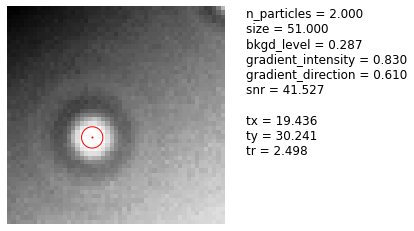

In [ ]:
test_image_spec = img_specs_df.iloc[0]
test_image = generate_image(test_image_spec)
annotate_image(test_image, test_image_spec)

### Save files to disk

NOTE: At the moment this is not the primary way to generate training data sets. See fastai_adaptor docs. 

In [ ]:
# export
from pathlib import Path

def save_img(data: np.ndarray, path, i:int):
        """
        Saves image data as a png file in path
        """
        img = (data-data.min())/data.max()
        PILImage.fromarray(np.uint8(img * 255) , 'L').save(path/f'{i}.png',format='png')
        return None

def generate_images(specs: pd.DataFrame, path):
    """
    Takes a dataframe of image specifications, creates images and saves to pth
    """
    Path(path).mkdir(parents=True, exist_ok=True)
    
    for ir, row in df.iterrows():
        img = generate_image(row)
        save_img(img, path, ir)
        

## References

[1] C. F. Bohren and D. R. Huffman,Absorption and Scattering of Light bySmall Particles(Wiley, 2008)


In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_GenerateSyntheticImages.ipynb.
Converted 01_models.ipynb.
Converted 02_Video.ipynb.
Converted 03_Measures.ipynb.
Converted 04_fastai_adpater.ipynb.
Converted 98_Display.ipynb.
Converted 99_cli.ipynb.
Converted E1_Track1.ipynb.
Converted E1a_Track.ipynb.
Converted E2_Track1fromN.ipynb.
Converted E3_multipleparticles.ipynb.
Converted index.ipynb.
